In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy import constants
from astropy.units import Quantity

from tqdm import tqdm

In [2]:
from src import utils,physics,nsphere,run_units,plot
from src.density.nfw import NFW
from src.density.hernquist import Hernquist
from src.spatial_approximation import Lattice
from src.halo import Halo
from src.background import Mass_Distribution

# Constants and general functions

In [3]:
dm_Mtot = Quantity(1.15e9,'Msun')
Rs = Quantity(1.18,'kpc')
c = 19
# dm_Mtot = Quantity(1.15e10,'Msun')
# Rs = Quantity(0.715,'kpc')
# c = 17
b_Mtot = Quantity(1e5,'Msun')
# sigma = Quantity(500,'cm^2/gram')
sigma = Quantity(50,'cm^2/gram')
# sigma = Quantity(0,'cm^2/gram')

dm_density = NFW(Rs=Rs,c=c,Mtot=dm_Mtot)
b_density = Hernquist(Rs=Rs,Rvir=c*Rs,Mtot=b_Mtot)

# Setup - DM

In [5]:
dm_n_particles = 1e5
dt = dm_density.Tdyn / 1000
save_every_time = 10*dm_density.Tdyn

halo = Halo.setup(densities=[dm_density],n_particles=[dm_n_particles],particle_types=['dm'],dt=dt,save_every_time=save_every_time,
                  scatter_params={'max_allowed_rounds':10,'kappa':0.02,'sigma':sigma},
                  dynamics_params={'grid_window_radius':50,'max_minirounds':20},hard_save='halo state')

In [ ]:
# halo.evolve(t=Quantity(17,'Gyr'))
halo.evolve(t=Quantity(5.91762741100472,'Gyr'))

  2%|█▍                                                            | 8020/332053 [09:21<5:06:06, 17.64it/s]/home/rotembarnea/Documents/SIDM/pySIDM/src/physics/leapfrog.py:366: UserWarning: Maximum number of mini-rounds reached for particle 135, starting with r=1.0065132102603291, vx=0.0028011981817215124, vy=-0.01949204548678843, vr=0.013155301299497088, M=1552500.0 solMass
  warnings.warn(
  3%|██                                                           | 10905/332053 [13:41<7:07:53, 12.51it/s]/home/rotembarnea/Documents/SIDM/pySIDM/src/physics/leapfrog.py:366: UserWarning: Maximum number of mini-rounds reached for particle 81, starting with r=27.364319205337935, vx=0.00017298809142036846, vy=0.0028932690059070617, vr=0.0040323516479938044, M=931500.0 solMass
  warnings.warn(
  4%|██▏                                                          | 11626/332053 [14:34<6:50:06, 13.02it/s]/home/rotembarnea/Documents/SIDM/pySIDM/src/physics/leapfrog.py:366: UserWarning: Maximum number of mini

In [23]:
halo.time.to('Gyr')

<Quantity 12.40685387 Gyr>

In [24]:
halo.save('test with SIDM')

In [173]:
time_range = Quantity([2,17],'Gyr')
# bins = Quantity(np.geomspace(1e-3,1e3,100),'kpc')
r_bins = Quantity(np.linspace(1e-3,5,100),'kpc')
density_units = run_units.density

sub = halo.snapshots[(halo.snapshots['time'] >= time_range[0])*(halo.snapshots['time'] <= time_range[1])]
sub = sub.to_pandas()
r_bin_volume = 4 / 3 * np.pi * (r_bins[1:] ** 3 - r_bins[:-1] ** 3)
grid = np.empty((len(np.unique(sub['time'])),len(r_bins)-1),dtype=np.float64)
for i,(_,group) in enumerate(sub.groupby('time')):
    result = group.groupby(pd.cut(Quantity(group['r'],'kpc').value, bins=r_bins.value),observed=False)['v_norm'].std()
    grid[i] = np.array(result)

In [29]:
time_range = Quantity([2,17],'Gyr')
# bins = Quantity(np.geomspace(1e-3,1e3,100),'kpc')
r_bins = Quantity(np.linspace(1e-3,5,100),'kpc')
density_units = run_units.density

sub = halo.snapshots[(halo.snapshots['time'] >= time_range[0])*(halo.snapshots['time'] <= time_range[1])]
r_bin_volume = 4 / 3 * np.pi * (r_bins[1:] ** 3 - r_bins[:-1] ** 3)
grid = np.empty((len(np.unique(sub['time'])),len(r_bins)-1),dtype=np.float64)
for i,group in enumerate(sub.group_by('time').groups):
    counts,_ = np.histogram(group['r'], bins=r_bins)
    density = (counts / r_bin_volume * halo.m[0]).to(density_units)
    # grid[i] = density
    grid[i] = counts
extent = (r_bins.min(),r_bins.max(),sub['time'].min(),sub['time'].max())

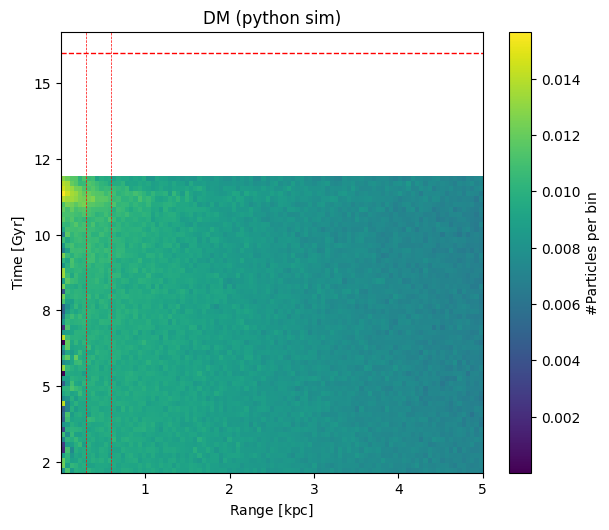

In [179]:
length_units = 'kpc'
time_units='Gyr'
xlabel = 'Range'
ylabel = 'Time'
cbar_label = '#Particles per bin'
kwargs = {}
fig,ax = plot.plot_2d(
    grid=grid,
    extent=extent,
    x_units=length_units,
    y_units=time_units,
    xlabel=utils.add_label_unit(xlabel, length_units),
    ylabel=utils.add_label_unit(ylabel, time_units),
    cbar_label=cbar_label,
    # title='Baryonic matter no DM background',
    title='DM (python sim)',
    **kwargs,
)
ax.axhline(y=16, color='red', linestyle='--', linewidth=1)
ax.axvline(x=0.3, color='red', linestyle='--', linewidth=0.5)
ax.axvline(x=0.6, color='red', linestyle='--', linewidth=0.5)

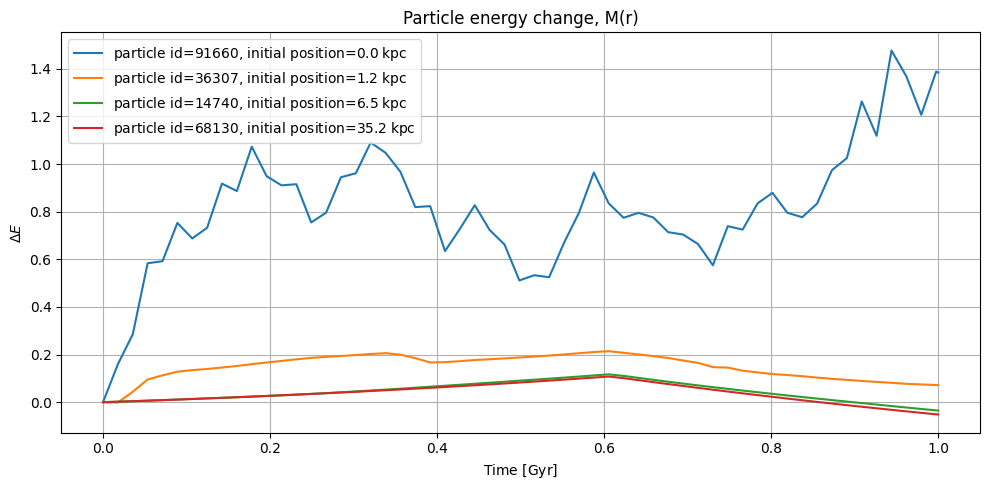

In [13]:
fig,ax = None,None
for particle_index in halo.initial_particles['particle_index'][[50,10000,50000,-50]]:
    fig,ax = halo.plot_trace(particle_index=particle_index,key='E',relative='change',ylabel=r'$\Delta E$',time_units='Gyr',
                             title='Particle energy change, M(r)',fig=fig,ax=ax,figsize=(10,5))

In [ ]:
halo.save('halo_state')

In [12]:
print(halo.print_energy_change_summary())

After 56111 steps with dt=0.0178 Myr | 1000.0 Myr
Total energy at the start:        714341.1 kpc2 solMass / Myr2
Total energy at the end:          713819.4 kpc2 solMass / Myr2
Energy change:                    521.7 kpc2 solMass / Myr2
Energy change per step:           9.3e-03 kpc2 solMass / Myr2
Energy change per dt:             2.9e+04 kpc2 solMass / Myr3
Relative energy change:           0.073%
Relative energy change per step:  1.3e-08
Relative energy change per dt:    4.098% 1 / Myr
Mean velocity change:             0.2 km / s
Mean velocity change per step:    2.8e-06 km / s
Mean velocity change per dt:      8.7e+00 km / (Myr s)
Relative Mean velocity change:    0.921%


Text(0.5, 1.0, 'Energy change in pythom sim, relative change = 2.0%')

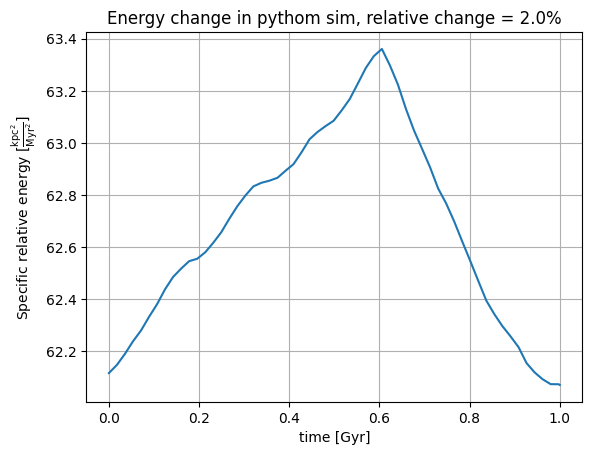

In [14]:
from astropy import table
data = table.vstack([halo.initial_particles,halo.snapshots,halo.particles])
agg_data = utils.aggregate_QTable(data,'time','E','sum',{'E':run_units.energy}).to_pandas()
agg_data['time'] /= 1000
agg_data = agg_data.set_index('time')['E'] / halo.m[0].value
mask = agg_data.index < np.inf
rel_diff = (agg_data[mask].max()-agg_data[mask].iloc[0])/agg_data[mask].iloc[0]
ax = sns.lineplot(agg_data[mask])
ax.grid(True)
ax.set_xlabel('time [Gyr]')
ax.set_ylabel(f'Specific relative energy [{run_units.specific_energy:latex}]')
ax.set_title(f'Energy change in pythom sim, relative change = {rel_diff:.1%}')

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Density progression over time'}, xlabel='Radius [$\\mathrm{kpc}$]', ylabel='Density'>)

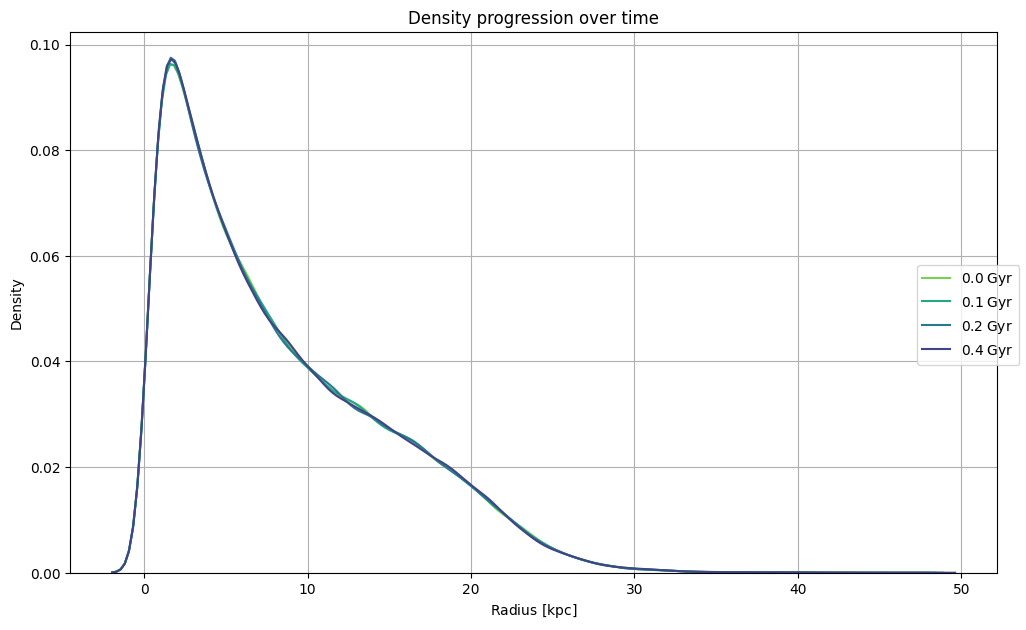

In [9]:
halo.plot_r_kde_over_time(figsize=(10,6),color_palette='viridis_r',indices=[0,4,10,20],time_units='Gyr')

## Analyze NSphere results

In [6]:
nsphere_all_data = nsphere.load_all_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,max_time=Quantity(19.605,'Gyr'),
                                          root_path='../../NSphere-SIDM/data/NO SIDM run')
nsphere_all_data['vp'] = nsphere_all_data['L']/nsphere_all_data['R']
nsphere_all_data['v_norm'] = np.sqrt(nsphere_all_data['vp']**2+nsphere_all_data['Vrad']**2)
nsphere_all_data['T'] = 1/2*nsphere_all_data['v_norm']**2
nsphere_all_data['particle_index'] = np.hstack([np.arange(100000)]*501)
nsphere_all_data = nsphere_all_data.rename(columns={'R':'r','Vrad':'vr'})
nsphere_initial_data = nsphere_all_data[nsphere_all_data['time'] == nsphere_all_data['time'].min()].copy().sort_values('r')
nsphere_unit_mass = Quantity(nsphere_initial_data['mass'].diff(1).iloc[-1],'Msun')

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:02<00:00, 224.75it/s]


### Radius distribution over time + halo distribution

In [ ]:
fig,ax = utils.setup_plot(xlabel=utils.add_label_unit('radius','kpc'),figsize=(10,6),title='Radius distribution over time NSphere')

times = all_data['time'].unique()
indices = []
for t in [0,1]:
    indices += [np.abs(times-t).argmin()]

colors = sns.color_palette('viridis_r', len(indices))

for i,(time,group) in enumerate(all_data.groupby('time')['r']):
    if i not in indices:
        continue
    sns.kdeplot(group,ax=ax,label=f'NSphere {Quantity(time,'Gyr').to_string(format='latex', formatter='.1f')}',color=colors[indices.index(i)])
    # sns.histplot(group,ax=ax,label=f'{Quantity(time,'Gyr').to_string(format='latex', formatter='.1f')}',stat='density')

sns.kdeplot(halo.initial_particles['r'],ax=ax,label=f'python sim {Quantity(0,'Gyr').to_string(format='latex', formatter='.1f')}',color=colors[0],linestyle='--')
sns.kdeplot(halo.particles['r'],ax=ax,label=f'python sim after {halo.time.to('Gyr').to_string(format='latex', formatter='.1f')}',color=colors[1],linestyle='--')

ax.legend()

### Energy change

#### Single particle trace

In [7]:
from astropy import table

In [8]:
data = table.QTable.from_pandas(nsphere_all_data,units={'r':'kpc','E':'kpc^2/Myr^2','time':'Gyr'})
data['E'] = data['E']*nsphere_unit_mass

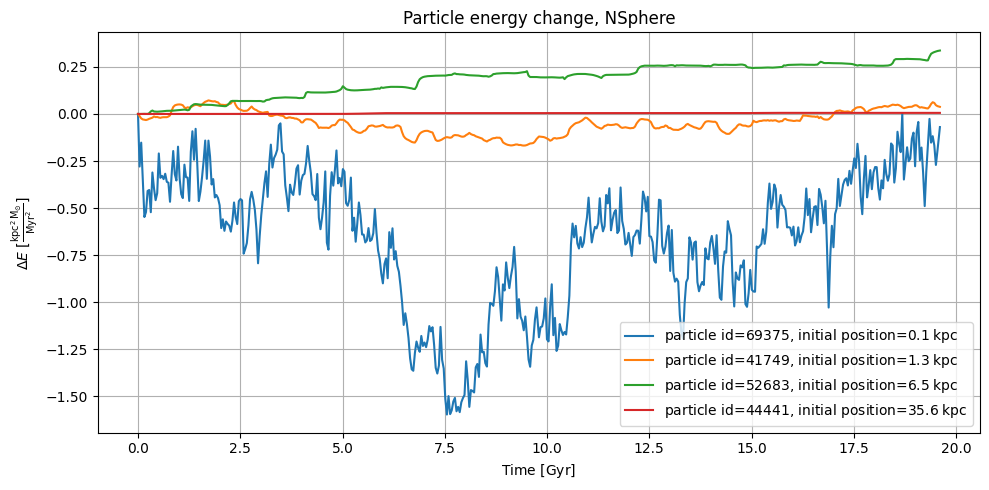

In [22]:
fig,ax = None,None
for particle_index in nsphere_initial_data['particle_index'].iloc[[50,10000,50000,-50]]:
    fig,ax = halo.plot_trace(data=data,particle_index=particle_index,key='E',relative='change',ylabel=r'$\Delta E$',time_units='Gyr',
                             y_units='Msun*kpc^2/Myr^2',title='Particle energy change, NSphere',fig=fig,ax=ax,figsize=(10,5))

In [ ]:
fig,ax = utils.setup_plot(xlabel=r'$\%\Delta E$',figsize=(10,6),title='Relative energy change distribution in NSphere')
sns.histplot(rel_dE,ax=ax)

In [37]:
rel_dE.sort_values()

72551    0.000000e+00
7884     1.975204e-07
95637    2.664351e-07
67468    3.182701e-07
79377    4.385512e-07
             ...     
72963    1.834234e-01
5520     1.845940e-01
72657    2.048725e-01
90154    2.131197e-01
10465    2.273645e-01
Name: E, Length: 100000, dtype: float32

In [ ]:
data = all_data.loc[all_data['particle_index'] == 10465].copy()
time = data['time']
E = (data['E']-data['E'].iloc[0])/data['E'].iloc[0]
ax = sns.lineplot(x=time,y=E)
ax.set_xlabel(r'Time $\left[\mathrm{Gyr}\right]$');
ax.set_ylabel(r'$\%\Delta E$')
ax.set_title(f'NSphere sim, initial particle radius {Quantity(data['R'].iloc[0],'kpc').to_string(format='latex', formatter='.1f')}')

#### Total energy

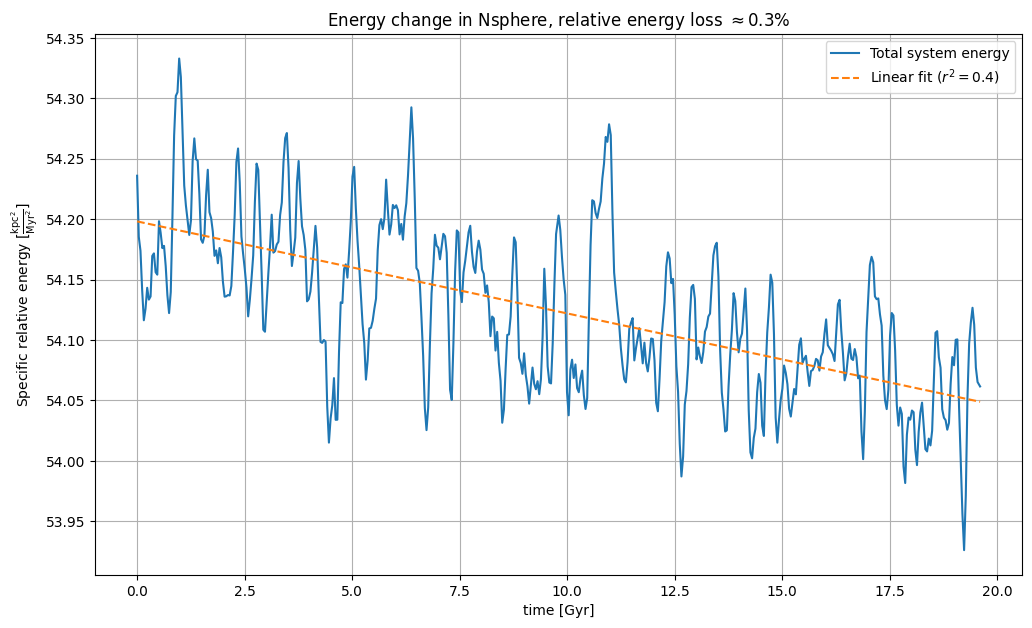

In [74]:
agg_data = all_data.groupby('time',sort=False)['E'].agg('sum')
slope = pd.DataFrame(agg_data).reset_index().cov().iloc[0,1]/np.var(agg_data.index)
intercept = agg_data.mean()-slope*np.mean(agg_data.index)
r2 = pd.DataFrame(agg_data).reset_index().corr().iloc[0,1]**2

x = np.array([agg_data.index[0],agg_data.index[-1]])
y = slope*x+intercept
rel_y = np.abs(y[1]-y[0])/y[0]

fig,ax = utils.setup_plot(xlabel='time [Gyr]',ylabel=f'Specific relative energy [{run_units.specific_energy:latex}]',figsize=(10,6),
                          title=rf'Energy change in Nsphere, relative energy loss $\approx${rel_y:.1%}')

sns.lineplot(agg_data,ax=ax,label='Total system energy')

sns.lineplot(x=x,y=slope*x+intercept,ax=ax,linestyle='--',label=f'Linear fit ($r^2={r2:.1f}$)');


## density calculations

In [14]:
initial = halo.initial_particles.copy()
final = halo.particles.copy()

In [15]:
bin_ends = units.Quantity(np.geomspace(1e-3,1,num=10),'kpc')
m_initial = []
m_final = []
volume = []
x = []
for start,end in list(zip(bin_ends,bin_ends[1:])):
    m_initial += [initial[(initial['r'] >= start)*(initial['r'] <= end)]['m'].sum()]
    m_final += [final[(final['r'] >= start)*(final['r'] <= end)]['m'].sum()]
    volume += [4/3*np.pi*(end**3-start**3)]
    x += [(end+start)/2]
m_initial = units.Quantity(m_initial)
m_final = units.Quantity(m_final)
volume = units.Quantity(volume,'kpc^3')
x = units.Quantity(x)
density_initial = m_initial/volume
density_final = m_final/volume

Text(0, 0.5, '$\\rho$ [$\\frac{M_\\odot}{kpc^3}$]')

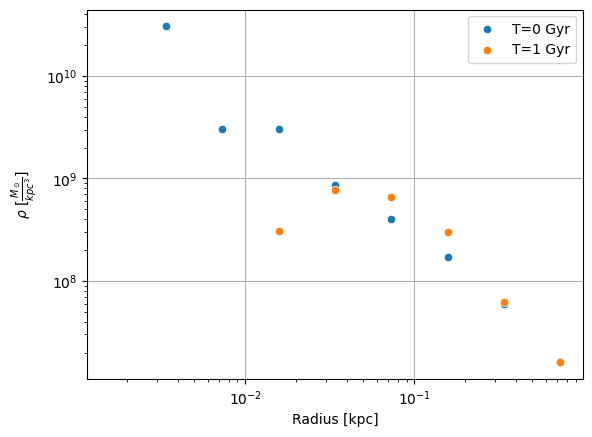

In [16]:
ax = sns.scatterplot(x=x,y=density_initial,label='T=0 Gyr')
sns.scatterplot(x=x,y=density_final,label='T=1 Gyr')
ax.grid(True)
ax.set(xscale='log',yscale='log')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel(r'$\rho$ [$\frac{M_\odot}{kpc^3}$]')

ERROR! Session/line number was not unique in database. History logging moved to new session 2316


(<Figure size 600x500 with 1 Axes>,
 <Axes: title={'center': 'Radius distribution'}, xlabel='Radius [$\\mathrm{kpc}$]', ylabel='Density'>)

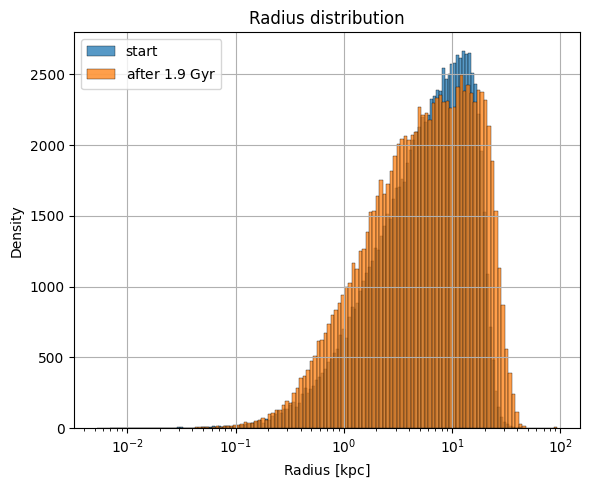

In [18]:
halo.plot_before_after_histogram(key='r',ax_set={'xscale':'log'},time_units='Gyr',stat='count',x_range=units.Quantity([0,100],'kpc'))

In [ ]:
halo.evolve(t=units.Quantity(20,'Gyr'))
# halo.evolve(t=units.Quantity(3,'Gyr'))
# halo.evolve(t=units.Quantity(1,'Gyr'))

In [16]:
halo.save()

ERROR! Session/line number was not unique in database. History logging moved to new session 2204


## Analysis

In [17]:
print(halo.print_energy_change_summary())

After 424736 steps with dt=0.0178 Myr | 7569.4 Myr
Total energy at the start:        199393.6 kpc2 solMass / Myr2
Total energy at the end:          104495.3 kpc2 solMass / Myr2
Energy change:                    94898.3 kpc2 solMass / Myr2
Energy change per step:           2.2e-01 kpc2 solMass / Myr2
Energy change per dt:             5.3e+06 kpc2 solMass / Myr3
Relative energy change:           47.593%
Relative energy change per step:  1.1e-06
Relative energy change per dt:    2670.590% 1 / Myr
Mean velocity change:             6.3 km / s
Mean velocity change per step:    1.5e-05 km / s
Mean velocity change per dt:      3.5e+02 km / (Myr s)
Relative Mean velocity change:    33.531%


In [14]:
initial = halo.initial_particles.copy()
final = halo.particles.copy()
f'{np.abs(final['E'].sum() - initial['E'].sum())/initial['E'].sum() / halo.current_step:.1e}'

'3.5e-08'

In [ ]:
halo.plot_scattering_density(time_units='Gyr',length_units='kpc');

In [ ]:
halo.plot_scattering_location(time_units='Myr',length_units='kpc');

In [ ]:
halo.plot_r_density_over_time(clip=units.Quantity([0,70],'kpc'));

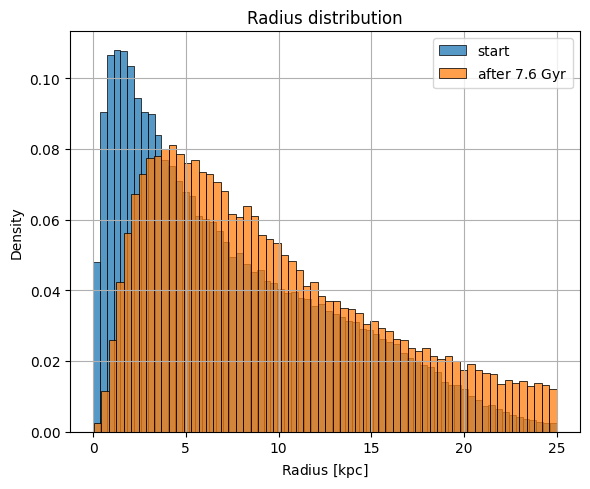

In [18]:
halo.plot_before_after_histogram(key='r',x_units='kpc',time_units='Gyr',x_range=units.Quantity([0,25],'kpc'));

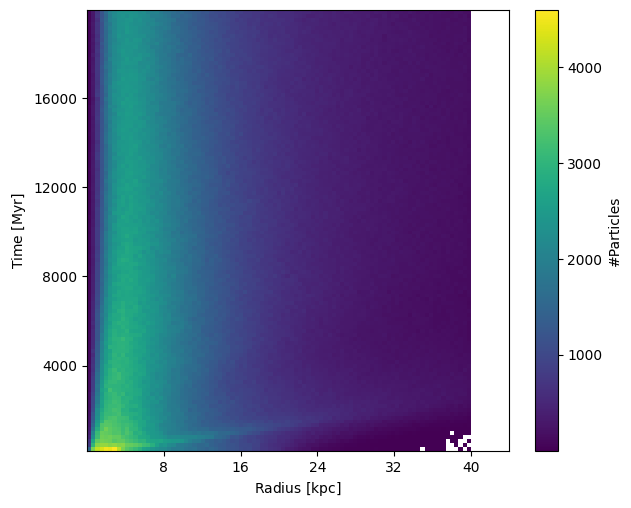

In [10]:
halo.plot_density_evolution(time_units='Myr');

In [ ]:
halo.plot_temperature(time_units='Gyr');

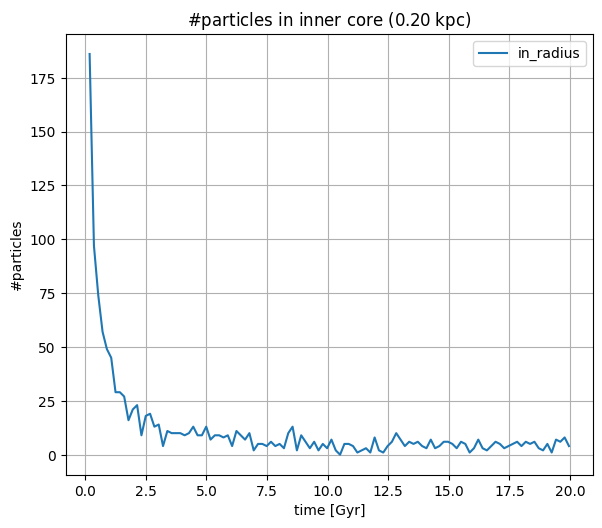

In [11]:
halo.plot_inner_core_density(radius=0.2*units.kpc,time_units='Gyr');

# Setup - B matter

## Full run

In [8]:
dm_n_particles = 1e5
b_n_particles = 1e4
dt = dm_density.Tdyn / 1000
save_every_time = 10*dm_density.Tdyn

halo = Halo.setup(densities=[dm_density,b_density],n_particles=[dm_n_particles,b_n_particles],particle_types=['dm','baryon'],dt=dt,
                  save_every_time=save_every_time,scatter_params={'max_allowed_rounds':10,'kappa':0.02,'sigma':sigma},
                  dynamics_params={'grid_window_radius':50,'max_minirounds':20,'raise_warning':False},hard_save='halo state')

In [ ]:
halo.evolve(t=Quantity(12,'Gyr'))

  0%|▏                                                             | 2357/673350 [01:58<9:05:09, 20.51it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 2410


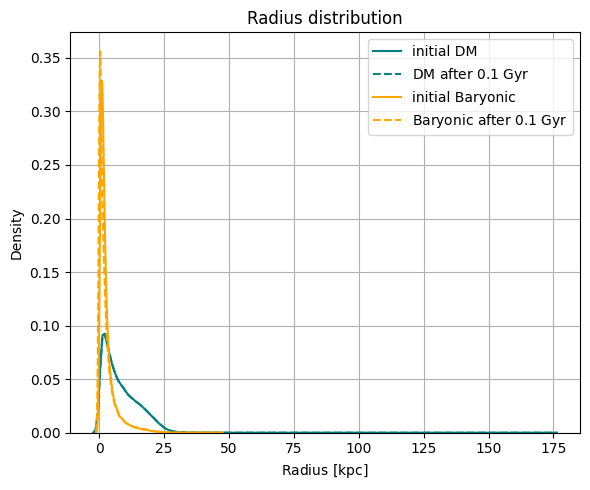

In [5]:
fig,ax=None,None
fig,ax=halo.plot_start_end_distribution(time_units='Gyr',x_range=Quantity([0,500],'kpc'),fig=fig,ax=ax,plot_type='kde',
                                        filter_particle_type='dm',label_start='initial DM',label_end='DM after {t}',
                                        start_kwargs={'plt_kwargs':{'color':'teal'}},
                                        end_kwargs={'plt_kwargs':{'color':'teal','linestyle':'--'}})
fig,ax=halo.plot_start_end_distribution(time_units='Gyr',x_range=Quantity([0,500],'kpc'),fig=fig,ax=ax,plot_type='kde',
                                        filter_particle_type='baryon',label_start='initial Baryonic',label_end='Baryonic after {t}',
                                        start_kwargs={'plt_kwargs':{'color':'orange'}},
                                        end_kwargs={'plt_kwargs':{'color':'orange','linestyle':'--'}})

## Background run

In [144]:
b_n_particles = 1e4
dt = dm_density.Tdyn / 1000
save_every_time = Quantity(100,'Myr')

# halo = Halo.setup(densities=[b_density],n_particles=[b_n_particles],particle_types=['baryon'],dt=dt,Tdyn=dm_density.Tdyn,
#                   save_every_time=save_every_time,dynamics_params={'grid_window_radius':50,'max_minirounds':50},
#                   background=Mass_Distribution.from_files(Mtot=dm_Mtot,base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,
#                                                           max_time=Quantity(19.605,'Gyr'),root_path='../../NSphere-SIDM/data/SIDM run'))
halo = Halo.setup(densities=[b_density],n_particles=[b_n_particles],particle_types=['baryon'],dt=dt,Tdyn=dm_density.Tdyn,
                  save_every_time=save_every_time,dynamics_params={'grid_window_radius':50,'max_minirounds':50})

In [106]:
nsphere_all_data,nsphere_initial_data,nsphere_unit_mass = nsphere.prepare_for_plotting(nsphere.load_all_files(**halo.background.load_kwargs))

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:02<00:00, 218.49it/s]


In [145]:
halo.evolve(t=Quantity(17,'Gyr'))

100%|███████████████████████████████████████████████████████████| 953913/953913 [1:06:20<00:00, 239.63it/s]


In [146]:
halo.save('run without any background')

In [37]:
np.abs(nsphere_all_data['time'].unique()-1.5).argmin()
# nsphere_all_data['time'].unique()[434]

np.int64(38)

In [156]:
halo = Halo.load('run with background')
# halo = Halo.load('run without any background')

In [162]:
from matplotlib.colors import LogNorm

In [179]:
time_range = Quantity([2,17],'Gyr')
# bins = Quantity(np.geomspace(1e-3,1e3,100),'kpc')
r_bins = Quantity(np.linspace(1e-3,5,100),'kpc')
density_units = run_units.density

sub = halo.snapshots[(halo.snapshots['time'] >= time_range[0])*(halo.snapshots['time'] <= time_range[1])]
r_bin_volume = 4 / 3 * np.pi * (r_bins[1:] ** 3 - r_bins[:-1] ** 3)
grid = np.empty((len(np.unique(sub['time'])),len(r_bins)-1),dtype=np.float64)
for i,group in enumerate(sub.group_by('time').groups):
    counts,_ = np.histogram(group['r'], bins=r_bins)
    density = (counts / r_bin_volume * halo.m[0]).to(density_units)
    # grid[i] = density
    grid[i] = counts
extent = (r_bins.min(),r_bins.max(),sub['time'].min(),sub['time'].max())

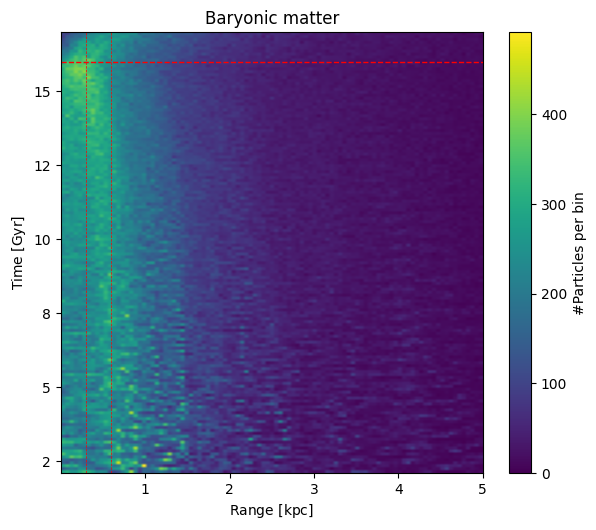

In [180]:
length_units = 'kpc'
time_units='Gyr'
xlabel = 'Range'
ylabel = 'Time'
cbar_label = '#Particles per bin'
kwargs = {}
fig,ax = plot.plot_2d(
    grid=grid,
    extent=extent,
    x_units=length_units,
    y_units=time_units,
    xlabel=utils.add_label_unit(xlabel, length_units),
    ylabel=utils.add_label_unit(ylabel, time_units),
    cbar_label=cbar_label,
    # title='Baryonic matter no DM background',
    title='Baryonic matter',
    **kwargs,
)
ax.axhline(y=16, color='red', linestyle='--', linewidth=1)
ax.axvline(x=0.3, color='red', linestyle='--', linewidth=0.5)
ax.axvline(x=0.6, color='red', linestyle='--', linewidth=0.5)

In [150]:
from astropy import table
time_range = Quantity([2,17],'Gyr')
# bins = Quantity(np.geomspace(1e-3,1e3,100),'kpc')
r_bins = Quantity(np.linspace(1e-3,5,100),'kpc')
density_units = run_units.density

nsphere_length_units = 'kpc'
nsphere_time_units = 'Gyr'

sub = nsphere_all_data[nsphere_all_data['time'].between(*time_range.to(nsphere_time_units).value)]
r_bin_volume = 4 / 3 * np.pi * (r_bins[1:] ** 3 - r_bins[:-1] ** 3)
grid = np.empty((len(np.unique(sub['time'])),len(r_bins)-1),dtype=np.float64)
for i,(time,group) in enumerate(sub.groupby('time')):
    counts,_ = np.histogram(Quantity(group['r'],nsphere_length_units), bins=r_bins.to(nsphere_length_units))
    density = (counts / r_bin_volume * halo.m[0]).to(density_units)
    grid[i] = counts
extent = (r_bins.min(),r_bins.max(),Quantity(sub['time'].min(),nsphere_time_units),Quantity(sub['time'].max(),nsphere_time_units))

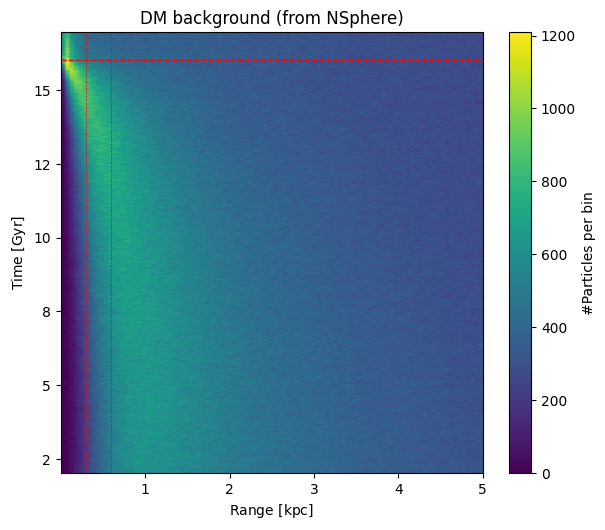

In [152]:
length_units = 'kpc'
time_units='Gyr'
xlabel = 'Range'
ylabel = 'Time'
cbar_label = '#Particles per bin'
kwargs = {}
fig,ax = plot.plot_2d(
    grid=grid,
    extent=extent,
    x_units=length_units,
    y_units=time_units,
    xlabel=utils.add_label_unit(xlabel, length_units),
    ylabel=utils.add_label_unit(ylabel, time_units),
    cbar_label=cbar_label,
    title='DM background (from NSphere)',
    **kwargs,
)
ax.axhline(y=16, color='red', linestyle='--', linewidth=1)
ax.axvline(x=0.3, color='red', linestyle='--', linewidth=0.5)
ax.axvline(x=0.6, color='red', linestyle='--', linewidth=0.5)

In [25]:
group['r']

<MaskedQuantity [1.83906748e-03, 2.56875821e-03, 3.67267662e-03, ...,
                 2.63307112e+01, 2.64852304e+01, 2.69096327e+01] kpc>

In [33]:
np.argmin(np.abs(np.unique(halo.snapshots['time'])-Quantity(1.5,'Gyr')))

np.int64(14)

In [40]:
x = halo.snapshots[halo.snapshots['time'] == np.unique(halo.snapshots['time'])[14]]
y = halo.snapshots[halo.snapshots['time'] == np.unique(halo.snapshots['time'])[164]]
data = pd.DataFrame({'initial':np.array(halo.initial_particles.to_pandas().sort_values('particle_index')['r']).astype(np.float64),
                     'max core':np.array(x.to_pandas().sort_values('particle_index')['r']).astype(np.float64),
                     'collapse':np.array(y.to_pandas().sort_values('particle_index')['r']).astype(np.float64)})

data.to_csv('baryonic all positions.csv',index=False)
times = Quantity([Quantity(0,'Myr'),x['time'][0],y['time'][0]]).to('Gyr')

In [50]:
x = nsphere_all_data[nsphere_all_data['time'] == np.unique(nsphere_all_data['time'])[38]]
y = nsphere_all_data[nsphere_all_data['time'] == np.unique(nsphere_all_data['time'])[383]]

data = pd.DataFrame({'initial':np.array(nsphere_initial_data.sort_values('particle_index')['r']),
                     'max core':np.array(x.sort_values('particle_index')['r']),
                     'collapse':np.array(y.sort_values('particle_index')['r'])})
data.to_csv('DM all positions.csv',index=False)
times = Quantity([0,x['time'].iloc[0],y['time'].iloc[0]],'Gyr')

In [51]:
import pandas as pd
import numpy as np

data = pd.read_csv('baryonic all positions.csv')
unit_mass = 1e5/1e4
bins = np.geomspace(1e-3,1e3,100)

def process(r,bins,unit_mass):
    counts, bin_edges = np.histogram(r, bins=bins)
    histogram_bins = np.array(list(zip(bin_edges, bin_edges[1:])))
    bin_centers = histogram_bins.mean(1)
    volume = 4 / 3 * np.pi * (histogram_bins[:, 1] ** 3 - histogram_bins[:, 0] ** 3)
    density = (counts / volume * unit_mass)
    return pd.DataFrame({'bin_centers':bin_centers,'volume':volume,'counts':counts,'density':density})

binned_data = pd.concat([process(data[column],bins,unit_mass).rename(columns={'counts':f'{column} counts','density':f'{column} density'})
                         for column in data],axis=1)
binned_data = binned_data.loc[:,~binned_data.columns.duplicated()].copy()
binned_data.to_csv('baryonic binned data.csv',index=False)

In [52]:
import pandas as pd
import numpy as np

data = pd.read_csv('DM all positions.csv')
unit_mass = 1.15e9/1e5
bins = np.geomspace(1e-3,1e3,100)

def process(r,bins,unit_mass):
    counts, bin_edges = np.histogram(r, bins=bins)
    histogram_bins = np.array(list(zip(bin_edges, bin_edges[1:])))
    bin_centers = histogram_bins.mean(1)
    volume = 4 / 3 * np.pi * (histogram_bins[:, 1] ** 3 - histogram_bins[:, 0] ** 3)
    density = (counts / volume * unit_mass)
    return pd.DataFrame({'bin_centers':bin_centers,'volume':volume,'counts':counts,'density':density})

binned_data = pd.concat([process(data[column],bins,unit_mass).rename(columns={'counts':f'{column} counts','density':f'{column} density'})
                         for column in data],axis=1)
binned_data = binned_data.loc[:,~binned_data.columns.duplicated()].copy()
binned_data.to_csv('DM binned data.csv',index=False)

In [34]:
initial = halo.initial_particles.to_pandas()
snapshots = halo.snapshots.to_pandas()
now = halo.particles.to_pandas()

pd.concat([initial,snapshots,now],ignore_index=True).drop(columns='step').to_csv('Baryonic particles.csv')

In [42]:
x = nsphere_all_data.drop(columns=['rank','mass','PsiA','L','T'])

In [43]:
x.to_pickle('dm particles.pkl')

Text(0.5, 1.0, 'Baryonic matter radius distribution')

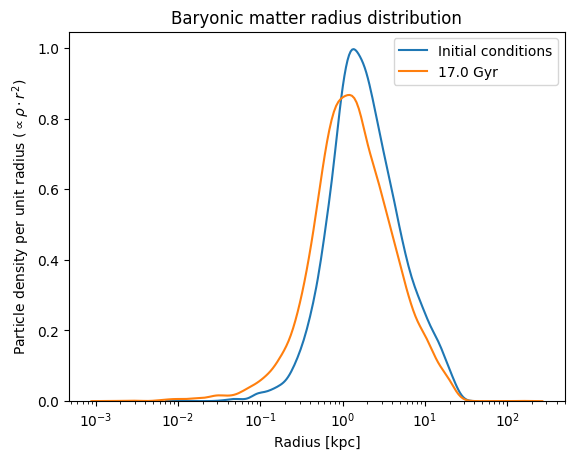

In [51]:
ax = sns.kdeplot(np.array(halo.initial_particles['r']).astype(np.float64),log_scale=True,label='Initial conditions')
sns.kdeplot(halo.particles['r'],log_scale=True,ax=ax,label=f'{halo.time.to('Gyr'):.1f}')
ax.legend()
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel(r'Particle density per unit radius ($\propto \rho\cdot r^2$)')
ax.set_title('Baryonic matter radius distribution')

(0.01, 30.0)

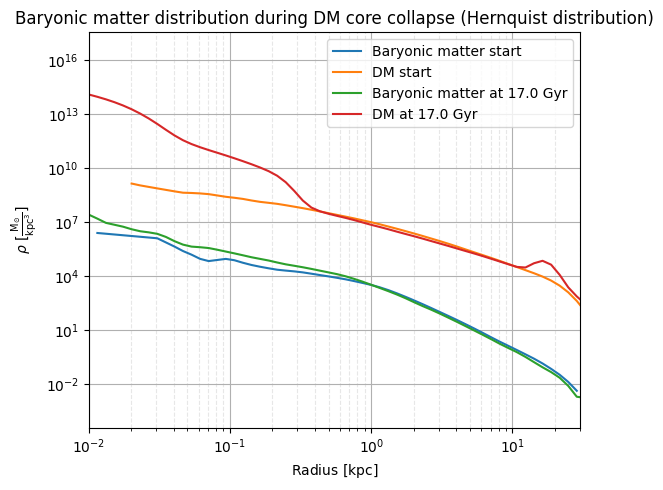

In [29]:
bins = Quantity(np.geomspace(1e-3,1e3,100),'kpc')
fig,ax = plot.plot_density(halo.initial_particles['r'],label='Baryonic matter start',unit_mass=halo.m[0],bins=bins)
fig,ax = plot.plot_density(Quantity(nsphere_initial_data['r'],'kpc'),label='DM start',unit_mass=nsphere_unit_mass,bins=bins,fig=fig,ax=ax)
fig,ax = plot.plot_density(halo.particles['r'],fig=fig,ax=ax,label=f'Baryonic matter at {halo.time.to('Gyr'):.1f}',bins=bins,unit_mass=halo.m[0])
fig,ax = plot.plot_density(Quantity(nsphere_all_data[nsphere_all_data['save_step']==869],'kpc'),label='DM at 17.0 Gyr',unit_mass=nsphere_unit_mass,
                           bins=bins,fig=fig,ax=ax,title='Baryonic matter distribution during DM core collapse (Hernquist distribution)')
ax.set_xlim([1e-2,0.3e2])

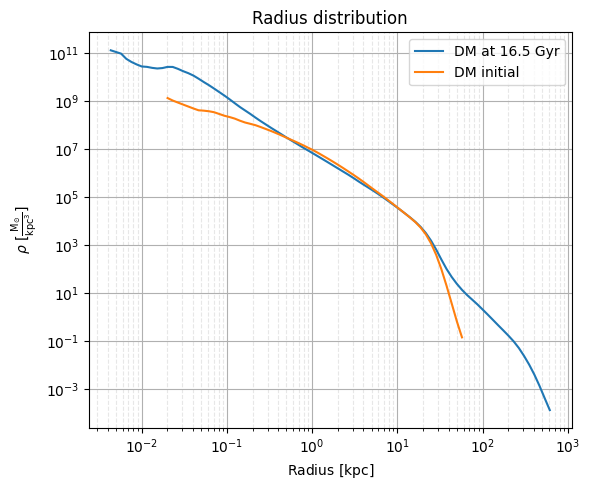

In [7]:
t = Quantity(nsphere_all_data[nsphere_all_data['save_step'] == 845]['time'].iloc[0],'Gyr')
fig,ax = plot.plot_density(Quantity(nsphere_all_data[nsphere_all_data['save_step'] == 845]['r'],'kpc'),label=f'DM at {t:.1f}',
                           unit_mass=nsphere_unit_mass,bins=Quantity(np.geomspace(1e-3,1e3,100),'kpc'))
fig,ax = plot.plot_density(Quantity(nsphere_initial_data['r'],'kpc'),label='DM initial',unit_mass=nsphere_unit_mass,
                           bins=Quantity(np.geomspace(1e-3,1e3,100),'kpc'),fig=fig,ax=ax)

## dm plots

In [8]:
data = nsphere.to_saved_state_like(nsphere.load_all_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,
                                                          max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data'))

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:01<00:00, 346.59it/s]


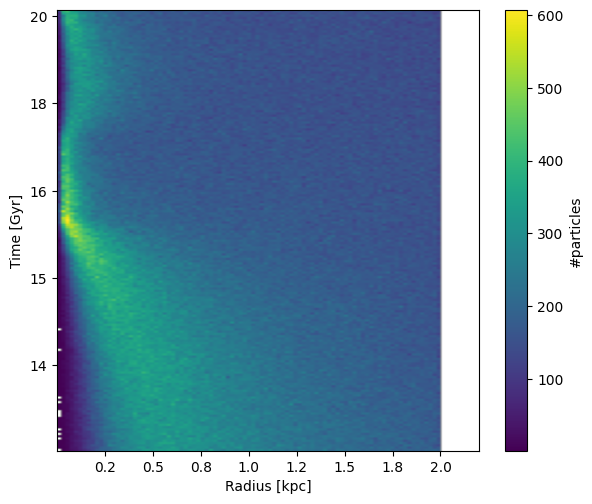

In [17]:
data['output'] = (data.v_norm/(km/second))**2
time_units={'name':'Gyr','value':Gyr}
length_units={'name':'kpc','value':kpc}
grid,extent = halo.prep_2d_data(data,radius_range=(0,2*kpc),time_range=(12*Gyr,20*Gyr),x_units=length_units,time_units=time_units,agg_fn='count')

utils.plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='#particles',
              x_nbins=10,x_tick_format='%.1f');

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agg_data = pd.concat([agg_data,pad]).drop_duplicates(['time','bin']).sort_values(['time','bin'])


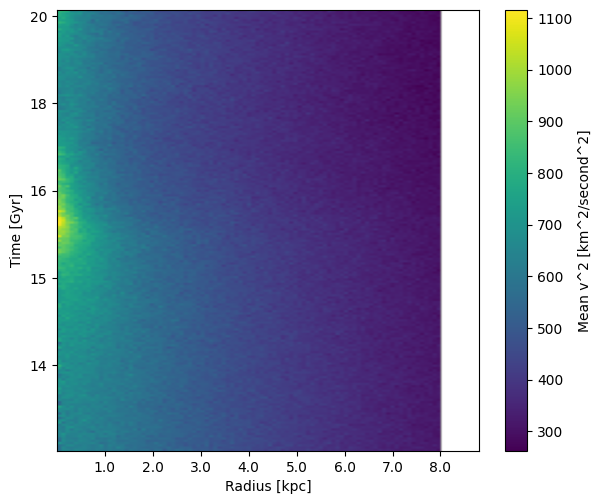

In [26]:
data['output'] = (data.v_norm/(km/second))**2
time_units={'name':'Gyr','value':Gyr}
length_units={'name':'kpc','value':kpc}
grid,extent = halo.prep_2d_data(data,radius_range=(0,8*kpc),x_units=length_units,time_units=time_units,agg_fn='mean')

utils.plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',
              cbar_label='Mean v^2 [km^2/second^2]');

In [68]:
data = nsphere.load_all_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,
                              max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data')
data['v^2'] = data['Vrad']**2+(data['L']/data['R'])**2
data['time'] /= Gyr

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:02<00:00, 212.54it/s]


In [72]:
data['Etot'] = data['E'] + data['PsiA']

In [ ]:
agg_data_E = data.groupby('time').E.agg('sum')
agg_data_Etot = data.groupby('time').E_tot.agg('sum')
agg_data_v2 = data.groupby('time')['v^2'].agg('sum')

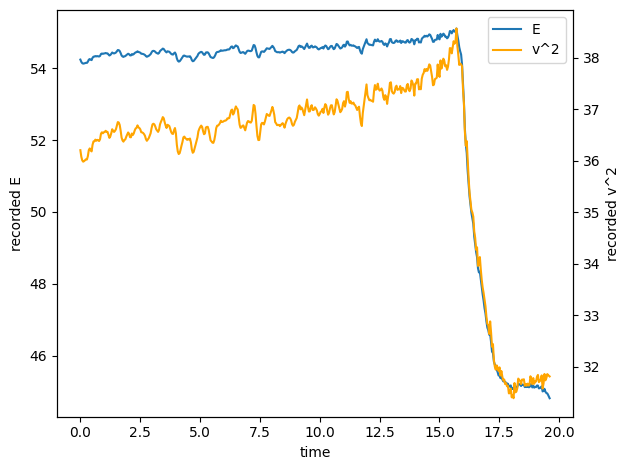

In [70]:
fig,ax1 = plt.subplots()
ax = sns.lineplot(agg_data_E,label='E')
ax1.set_ylabel('recorded E')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.lineplot(data=agg_data_v2,ax=ax2,color='orange',label='v^2')
ax2.set_ylabel('recorded v^2')
ax2.tick_params(axis='y')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.legend(lines1 + lines2, ['E', 'v^2'], loc='upper right')

# Add title and show
plt.tight_layout()

# Initial NFW distributions:

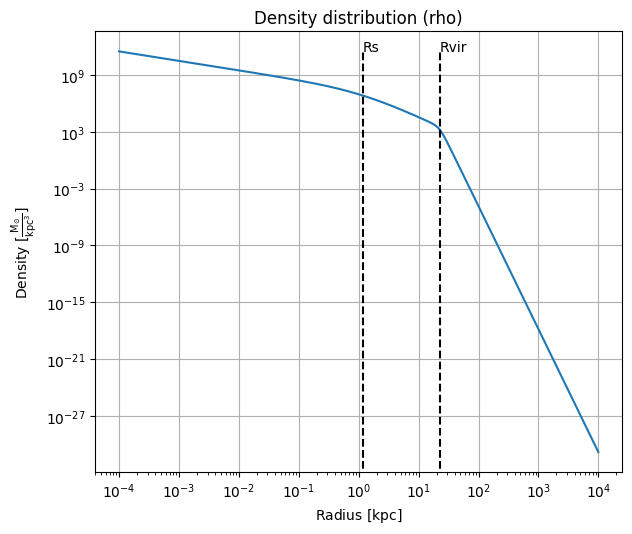

In [5]:
halo.densities[0].plot_rho();

In [9]:
nsphere_all_data = nsphere.load_all_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,max_time=Quantity(19.605,'Gyr'),
                                          root_path='../../NSphere-SIDM/data/NO SIDM run')
nsphere_all_data['vp'] = nsphere_all_data['L']/nsphere_all_data['R']
nsphere_all_data['v_norm'] = np.sqrt(nsphere_all_data['vp']**2+nsphere_all_data['Vrad']**2)
nsphere_all_data['T'] = 1/2*nsphere_all_data['v_norm']**2
nsphere_all_data['particle_index'] = np.hstack([np.arange(100000)]*501)
nsphere_all_data = nsphere_all_data.rename(columns={'R':'r','Vrad':'vr'})
nsphere_initial_data = nsphere_all_data[nsphere_all_data['time'] == nsphere_all_data['time'].min()].copy().sort_values('R')

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:02<00:00, 236.68it/s]


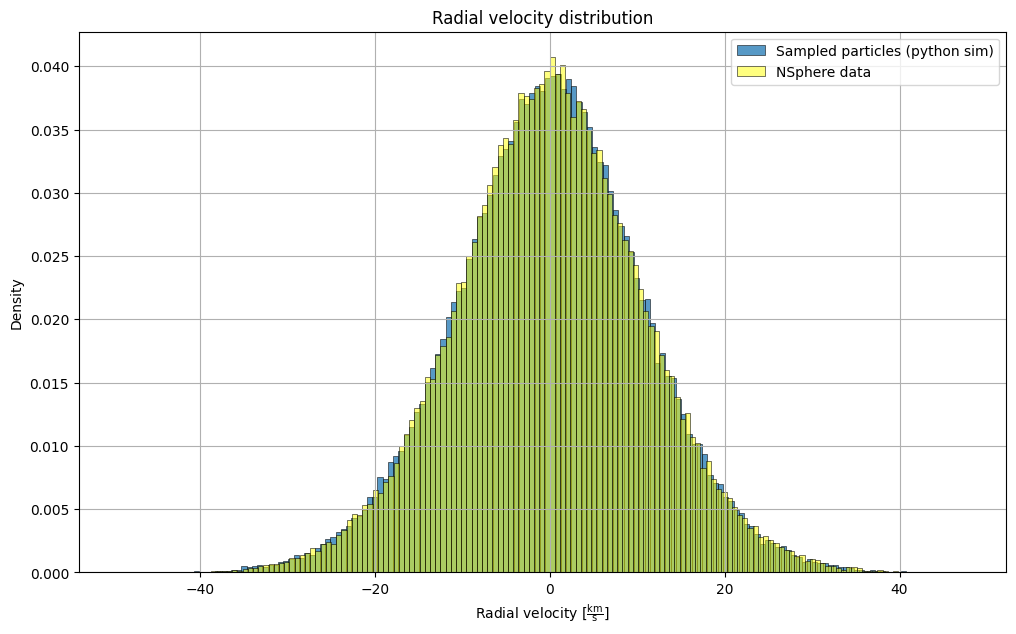

In [13]:
data = Quantity(nsphere_initial_data['vr'],'kpc/Myr').to('km/second')
fig,ax = halo.plot_distribution('vr',halo.initial_particles,figsize=(10,6),label='Sampled particles (python sim)')
sns.histplot(data,ax=ax,color='yellow',label='NSphere data',stat='density',alpha=0.5)

ax.legend()

In [ ]:
halo.densities[0].plot_phase_space();

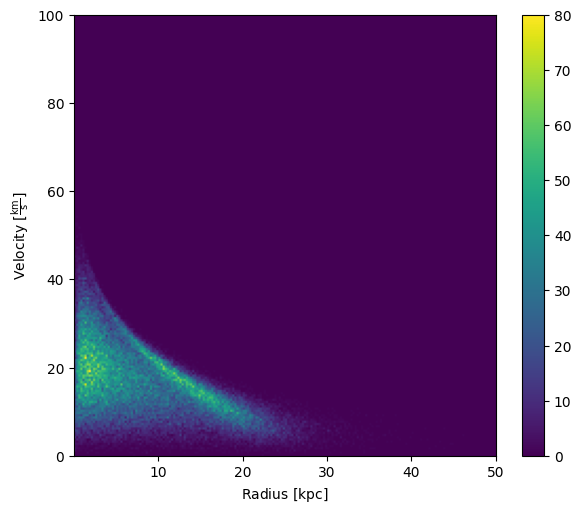

In [16]:
halo.plot_phase_space(halo.initial_particles);